In [2]:
import numpy as np
import pandas as pd
import re
import copy
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dir_path = 'drive/MyDrive/Data/linking-writing-processes-to-writing-quality/'

# First, read in the data

In [ ]:
testlog = pd.read_csv(dir_path+'test_logs.csv')
trainlog = pd.read_csv(dir_path+'train_logs.csv')
trainscore = pd.read_csv(dir_path+'train_scores.csv')


In [ ]:
print(trainlog.shape)

(8405898, 11)


In [ ]:
trainlog.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


In [ ]:
testlog.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,0000aaaa,1,338433,338518,85,Input,Space,Space,,0,0
1,0000aaaa,2,760073,760160,87,Input,Space,Space,,1,0
2,2222bbbb,1,711956,712023,67,Input,q,q,q,0,1
3,2222bbbb,2,290502,290548,46,Input,q,q,q,1,1
4,4444cccc,1,635547,635641,94,Input,Space,Space,,0,0


# Data description(From Kaggle):
- train_logs.csv - Input logs to be used as training data. To prevent reproduction of the essay text, all alphanumeric character inputs have been replaced with the "anonymous" character q; punctuation and other special characters have not been anonymized.
  - id - The unique ID of the essay
  - event_id - The index of the event, ordered chronologically
  - down_time - The time of the down event in milliseconds
  - up_time - The time of the up event in milliseconds
  - action_time - The duration of the event (the difference between down_time and up_time)
  - activity - The category of activity which the event belongs to
  - Nonproduction - The event does not alter the text in any way
  - Input - The event adds text to the essay
  - Remove/Cut - The event removes text from the essay
  - Paste - The event changes the text through a paste input
  - Replace - The event replaces a section of text with another string
  - Move From [x1, y1] To [x2, y2] - The event moves a section of text spanning character index x1, y1 to a new location x2, y2
  - down_event - The name of the event when the key/mouse is pressed
  - up_event - The name of the event when the key/mouse is released
  - text_change - The text that changed as a result of the event (if any)
  - cursor_position - The character index of the text cursor after the event
  - word_count - The word count of the essay after the event

First, I was curious about why the down_event and up_event columns are needed. One row of data should correspond to a single keyboard key press and release event. So, I tried to find rows where the values in these two columns are not the same.

In [ ]:
result = trainlog[trainlog['down_event'] != trainlog['up_event']]
result.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
5115,0042269b,105,104507,104617,110,Replace,q,m,qqqqqqq qqq qqqq qqqq qqqq qq qqqqqqqq qqqqqqq...,1,4
5232,0042269b,222,158578,158638,60,Replace,q,i,qqqqqqq => q,15,14
6276,0042269b,1266,473329,473439,110,Replace,q,o,qqq qq qqq qqqqqqq qqqqqq qqqq qq => q,194,128
6825,0042269b,1815,641821,641920,99,Replace,q,t,qqq qqqqq qq qqqqqqqq qqqq qqq qqqqqqq qq qqqq...,529,190
8223,0042269b,3213,1410198,1410293,95,Replace,q,a,qqqqqqq qqqqqqqqq qqqq qqq qq qqqq qqq qqqqqqq...,1539,282


In [ ]:
result.shape

(534, 11)

Then I found that there were 534 rows in the data where the values in the down_event and up_event columns were different. This is a small percentage of the entire dataset, which has 8405898 rows. However, the values in these rows were not limited to 'q', symbols, or keyboard keywords. They could be letters or even gibberish. According to the dataset description, all letter inputs have been processed as 'q'. Therefore, I believe that these rows are incorrect. In the following analysis, I will assume that all down_event values are equal to up_event values.

In [ ]:
result.to_csv(dir_path+'downup.csv', index=False)

# Next is the data preprocess part

Add the delta_cursor column to record the distance the cursor moves once.

In [ ]:
trainlog['delta_cursor'] = (trainlog['cursor_position'] - trainlog['cursor_position'].shift(1))
trainlog.loc[0, 'delta_cursor'] = 0

Add the movedis column to record the distance the text is moved in a Move operation. Add the movelength column to record the length of the text moved.

In [ ]:
def set_movedis_movelength(row):
    if re.search(r'Move From \[(\d+), (\d+)\] To \[(\d+), (\d+)\]', row['activity']):
        match = re.search(r'Move From \[(\d+), (\d+)\] To \[(\d+), (\d+)\]', row['activity'])
        x1, y1, x2, y2 = map(int, match.groups())
        dx = x2 - x1
        dy = y2 - y1
        dis = abs(x2 - x1)
        length = (y1 - x1)
    else:
        dis = 0
        length = 0
    return dis, length

trainlog['movedis'], trainlog['movelength'] = zip(*trainlog.apply(set_movedis_movelength, axis=1))

Add the pastelength column to record the length of the pasted string in a Paste operation

In [ ]:
def set_pastelength(row):
    if row['activity'] == 'Paste':
        return len(row['text_change'])
    else:
        return 0

trainlog['pastelength'] = trainlog.apply(set_pastelength, axis=1)

Add the replacelength column to record the difference in the number of characters replaced in each Replace operation.

In [ ]:
def set_replacelength(row):
    if row['activity'] == 'Replace':
        replace_text = row['text_change']
        before_text, after_text = replace_text.split(' => ')

        before_length = len(before_text)
        after_length = len(after_text)

        return before_length - after_length
    else:
        return 0

trainlog['replacelength'] = trainlog.apply(set_replacelength, axis=1)

Add the RClength column to record the number of characters deleted by the Remove/Cut action.

In [ ]:
def set_RClength(row):
    if row['activity'] == 'Remove/Cut':
        text_change = row['text_change']
        return len(text_change)
    else:
        return 0

trainlog['RClength'] = trainlog.apply(set_RClength, axis=1)

Process the down_event column to organize the event type into four categories.

In [ ]:
trainlog = trainlog.drop("up_event", axis=1) # assumes that up_event is equal to down_event

In [ ]:
Keyboard_keywords = ['Leftclick', 'Shift', 'Backspace', 'Enter', 'ArrowLeft', 'ArrowRight', 'Tab', 'ArrowUp', 'ArrowDown', 'Rightclick',
           'CapsLock', 'Control', 'Delete', 'Home', 'End', 'Insert', 'NumLock', 'Alt',
           'ContextMenu','PageDown', 'Middleclick', 'ScrollLock', 'Space',
           'Cancel', 'Escape', 'Clear', 'OS']
for i in range(1,16):
  Keyboard_keywords.append('F'+str(i))#F1--F15
Media_keywords = ['Meta','AudioVolumeMute','MediaPlayPause','AudioVolumeUp','AudioVolumeDown','MediaTrackPrevious', 'MediaTrackNext', 'Pause']
Other_keywords = ['Dead', 'Process', 'AltGraph',]
Unknown_keywords = ['Unidentified','Unknownclick']

In [ ]:
trainlog['keyword'] = 0
def convert_down_event_char(value):
    if len(value) == 1 and (value.isalpha() or value.isdigit()):
        return 'q'
    elif value in Keyboard_keywords:
        return "keyboard_keyword"
    elif value in Media_keywords:
        return "media_keyword"
    elif value in Other_keywords:
        return "other_keyword"
    elif value in Unknown_keywords:
        return "unknown_keyword"
    else:
        return "unknown_keyword"

trainlog['keyword'] = trainlog['down_event'].apply(convert_down_event_char)

Organize the 6 possible actions in the activity column into numerical representations.

In [ ]:
actype = {0:'Nonproduction',
      1:'Input',
      2:'Remove/Cut',
      3:'Paste',
      4:'Replace',
      5:'Move'
      }

In [ ]:
def set_activity(row):
    if row['activity'] == 'Nonproduction':
        return 0
    elif row['activity'] == 'Input':
        return 1
    elif row['activity'] == 'Remove/Cut':
        return 2
    elif row['activity'] == 'Paste':
        return 3
    elif row['activity'] == 'Replace':
        return 4
    else:
      return 5

trainlog['actype'] = trainlog.apply(set_activity,axis=1)

Add the thinktime and contype columns to record the thinking time and the continuous typing situation. The time interval between the release of the last key and the press of the next key is considered as the thinking time. If the next key is pressed before the last key is released, it is considered as a continuous typing.

In [ ]:
trainlog['thinktime'] = 0
trainlog['contype'] = 0

trainlog['thinktime'] = trainlog['down_time'] - trainlog['up_time'].shift()
trainlog['thinktime'] = trainlog['thinktime'].clip(lower=0)

trainlog['contype'] = (trainlog['down_time'] <= trainlog['up_time'].shift()).astype(int)

drop some colums which is useless

In [ ]:
trainlog = trainlog.drop("activity", axis=1)
trainlog = trainlog.drop("down_event", axis=1)
trainlog = trainlog.drop("text_change", axis=1)
trainlog = trainlog.drop("cursor_position", axis=1)

In [ ]:
trainlog.to_csv(dir_path+'trainlog1.csv', index=False)

In [ ]:
result = trainlog[trainlog['thinktime'] > 1]
result.head()

,id,event_id,down_time,up_time,action_time,word_count,delta_cursor,movedis,movelength,pastelength,replacelength,RClength,keyword,actype,thinktime,contype
2,001519c8,3,106571,106571,0,0,0.0,0,0,0,0,0,keyboard_keyword,0,101609.0,0
3,001519c8,4,106686,106777,91,1,1.0,0,0,0,0,0,q,1,115.0,0
4,001519c8,5,107196,107323,127,1,1.0,0,0,0,0,0,q,1,419.0,0
6,001519c8,7,107469,107596,127,1,1.0,0,0,0,0,0,q,1,69.0,0
7,001519c8,8,107659,107766,107,1,1.0,0,0,0,0,0,q,1,63.0,0


## Each column name and its description
- id - Unique ID of the article
- event_id - Index of the event, sorted in chronological order
- down_time - Time of the press event (in milliseconds)
- up_time - Time of the release event (in milliseconds)
- action_time - Duration of the event (difference between `down_time` and `up_time`)
- delta_cursor - Distance the cursor moved after each action
- movedis - Distance moved in the Move operation
- movelength - Length of the string moved in the Move operation
- pastelength - Length of the string pasted in one paste operation
- replacelength - Difference in length of the string replaced in one replace operation
- RClength - Length of the string removed/cut in one Remove/Cut operation
- thinktime - Time spent on thinking
- contype - Indicates whether it is a continuous press
- actype - Type of action:
      0: Nonproduction,
      1: Input,
      2: Remove/Cut,
      3: Paste,
      4: Replace,
      5: Move



# Next is the feature extraction part.

The difficulty of feature extraction is that the number of operations in each article is not the same. Therefore, we need to find a set of features with the same dimension to describe the operations in each article.

In [ ]:
#trainlog = pd.read_csv(dir_path+'trainlog1.csv')

Data Processing ideas:

- Create a new dataframe variable called traindata.

- Iterate over trainlog using the id as the identifier. Rows with the same id represent information about writing an article. Perform the following processing steps for each article's relevant information:

  - Record the article ID as id.
  - Calculate the total word count by using the value in the word_count column of the last row and store it as word_count.
  - Count the number of continuous presses by counting the rows where the contype value is 1 and store it as contype_count.
  - Calculate the total thinking time by summing up the thinktime values of all rows and store it as total_think.
  - Calculate the total time used by subtracting the up_time value of the last row from the down_event value of the first row, and store it as total_time.
  - Count the total number of actions by counting the rows and store it as action_count.
  - Calculate the total action time by summing up the actiontime values of all rows and store it as total_actiontime.
  - Count the occurrences of the 4 different values in the keyword column separately and store them as keyword_count, media_count, other_count, and unknown_count.
  - Count the occurrences of values in the delta_cursor column that are greater than or equal to zero within the ranges 0-1, 2-10, 11-30, 31-80, and greater than 80, and store them as dc0, dc1, dc2, dc3, and dc4. Count the occurrences of values in the delta_cursor column that are less than zero within the ranges -1 to -1, -2 to -10, -11 to -30, -31 to -80, and less than -80, and store them as dc5, dc6, dc7, dc8, and dc9.
  - Count the occurrences of values in the movedis column within the ranges 0-1, 2-10, 11-30, 31-80, and greater than 80, and store them as md0, md1, md2, md3, and md4.
  - Count the occurrences of values in the movelength column within the ranges 0-5, 6-15, 16-30, 31-80, and greater than 80, and store them as ml0, ml1, ml2, ml3, and ml4.
  - Count the occurrences of values in the pastelength column within the ranges 0-1, 2-10, 11-30, 31-80, and greater than 80, and store them as pl0, pl1, pl2, pl3, and pl4.
  - Count the occurrences of values in the replacelength column within the ranges 0-1, 2-10, 11-30, 31-80, and greater than 80, and store them as rl0, rl1, rl2, rl3, and rl4.
  - Count the occurrences of values in the RClength column within the ranges 0-1, 2-10, 11-30, 31-80, and greater than 80, and store them as rc0, rc1, rc2, rc3, and rc4.
  - Count the occurrences of the 6 different values in the actype column separately and store them as ac0, ac1, ac2, ac3, ac4, and ac5.
  - Count the occurrences of continuous inputs, where continuous inputs refer to consecutive rows where the actype value is 1 and the actype value for the preceding and succeeding rows is not 1.
  - For the defined continuous inputs in the previous step, calculate the length of each continuous input, which is the number of rows in each continuous input. Calculate the maximum, mean, median, and variance of all the calculated row lengths.
  - Store all the above information in traindata.

These data features are the ones I can think of that can be used to represent the writing habits of writers.

The goal of this project is to predict the final score of an article by analyzing the writing habits based on the operation records during writing. Currently, some participants in Kaggle use the idea of traversing all operation information to reconstruct the entire article, and then extract features from the reconstructed article for model training and prediction. I believe that this approach deviates from the project topic. Therefore, I chose the above features to characterize the writing habits of writers, such as thinking time, continuous typing times, the length of the pasted string in each paste operation, the number of continuous inputs, and the length.

I believe that these features can be used to characterize writing habits to some extent. For example, writers with a longer continuous input length may have a more coherent writing idea than writers with a shorter continuous input length, and the quality of their writing may be better. Similarly, writers with a coherent writing idea should have a shorter string length for each cut and paste operation, and so on. In the end, a total of 56-dimensional features were extracted.

In [ ]:
traindata = pd.DataFrame()

for id_value, group in tqdm(trainlog.groupby('id')):
    word_count = group['word_count'].iloc[-1]

    contype_count = group['contype'].eq(1).sum()

    total_think = group['thinktime'].sum()

    total_time = group['up_time'].iloc[-1] - group['down_time'].iloc[0]

    action_count = group.shape[0]

    total_actiontime = group['action_time'].sum()

    keyword_counts = group['keyword'].value_counts()
    keyboard_count = keyword_counts.get('keyboard_keyword', 0)
    media_count = keyword_counts.get('media_keyword', 0)
    other_count = keyword_counts.get('other_keyword', 0)
    unknown_count = keyword_counts.get('unknown_keyword', 0)

    delta_cursor = group['delta_cursor']
    dc0 = delta_cursor.between(0, 1).sum()
    dc1 = delta_cursor.between(2, 10).sum()
    dc2 = delta_cursor.between(11, 30).sum()
    dc3 = delta_cursor.between(31, 80).sum()
    dc4 = (delta_cursor > 80).sum()
    dc5 = delta_cursor.between(-1, -1).sum()
    dc6 = delta_cursor.between(-10, -2).sum()
    dc7 = delta_cursor.between(-30, -11).sum()
    dc8 = delta_cursor.between(-80, -31).sum()
    dc9 = (delta_cursor < -80).sum()

    movedis = group['movedis']
    md0 = movedis.between(0, 1).sum()
    md1 = movedis.between(2, 10).sum()
    md2 = movedis.between(11, 30).sum()
    md3 = movedis.between(31, 80).sum()
    md4 = (movedis > 80).sum()

    movelength = group['movelength']
    ml0 = movelength.between(0, 5).sum()
    ml1 = movelength.between(6, 15).sum()
    ml2 = movelength.between(16, 30).sum()
    ml3 = movelength.between(31, 80).sum()
    ml4 = (movelength > 80).sum()

    pastelength = group['pastelength']
    pl0 = pastelength.between(0, 1).sum()
    pl1 = pastelength.between(2, 10).sum()
    pl2 = pastelength.between(11, 30).sum()
    pl3 = pastelength.between(31, 80).sum()
    pl4 = (pastelength > 80).sum()

    replacelength = group['replacelength']
    rl0 = replacelength.between(0, 1).sum()
    rl1 = replacelength.between(2, 10).sum()
    rl2 = replacelength.between(11, 30).sum()
    rl3 = replacelength.between(31, 80).sum()
    rl4 = (replacelength > 80).sum()

    RClength = group['RClength']
    rc0 = RClength.between(0, 1).sum()
    rc1 = RClength.between(2, 10).sum()
    rc2 = RClength.between(11, 30).sum()
    rc3 = RClength.between(31, 80).sum()
    rc4 = (RClength > 80).sum()

    actype_counts = group['actype'].value_counts()
    ac0 = actype_counts.get(0, 0)
    ac1 = actype_counts.get(1, 0)
    ac2 = actype_counts.get(2, 0)
    ac3 = actype_counts.get(3, 0)
    ac4 = actype_counts.get(4, 0)
    ac5 = actype_counts.get(5, 0)

    consecutive_input_count = 0
    consecutive_input_lengths = [1]
    prev_action_type = None
    for index, row in group.iterrows():
      current_action_type = row['actype']
      if prev_action_type == 1 and current_action_type != 1:
          consecutive_input_count += 1
          consecutive_input_lengths.append(0)
      elif prev_action_type == 1 and current_action_type == 1:
          consecutive_input_lengths[-1] += 1
      prev_action_type = current_action_type

    traindata = traindata.append(
        {
            'id': id_value,
            'word_count': word_count,
            'contype_count': contype_count,
            'total_think': total_think,
            'total_time': total_time,
            'action_count': action_count,
            'total_actiontime': total_actiontime,
            'keyboard_count': keyboard_count,
            'media_count': media_count,
            'other_count': other_count,
            'unknown_count': unknown_count,
            'dc0': dc0,
            'dc1': dc1,
            'dc2': dc2,
            'dc3': dc3,
            'dc4': dc4,
            'dc5': dc5,
            'dc6': dc6,
            'dc7': dc7,
            'dc8': dc8,
            'dc9': dc9,
            'md0': md0,
            'md1': md1,
            'md2': md2,
            'md3': md3,
            'md4': md4,
            'ml0': ml0,
            'ml1': ml1,
            'ml2': ml2,
            'ml3': ml3,
            'ml4': ml4,
            'pl0': pl0,
            'pl1': pl1,
            'pl2': pl2,
            'pl3': pl3,
            'pl4': pl4,
            'rl0': rl0,
            'rl1': rl1,
            'rl2': rl2,
            'rl3': rl3,
            'rl4': rl4,
            'rc0': rc0,
            'rc1': rc1,
            'rc2': rc2,
            'rc3': rc3,
            'rc4': rc4,
            'ac0': ac0,
            'ac1': ac1,
            'ac2': ac2,
            'ac3': ac3,
            'ac4': ac4,
            'ac5': ac5,
            'consecutive_input_count': consecutive_input_count,
            'consecutive_input_max': consecutive_input_max,
            'consecutive_input_mean': consecutive_input_mean,
            'consecutive_input_mid': consecutive_input_median,
            'consecutive_input_var': consecutive_input_variance,
        },
        ignore_index=True
    )

100%|██████████| 2471/2471 [00:58<00:00, 42.52it/s]


In [ ]:
traindata.to_csv(dir_path+'traindata.csv', index=False)

# Let's try to combine all data preprocessing and feature extraction into a single function.

## These are all self-defined functions in data preprocess part

In [4]:
def set_movedis_movelength(row):
    if re.search(r'Move From \[(\d+), (\d+)\] To \[(\d+), (\d+)\]', row['activity']):
        match = re.search(r'Move From \[(\d+), (\d+)\] To \[(\d+), (\d+)\]', row['activity'])
        x1, y1, x2, y2 = map(int, match.groups())
        dx = x2 - x1
        dy = y2 - y1
        dis = abs(x2 - x1)
        length = (y1 - x1)
    else:
        dis = 0
        length = 0
    return dis, length

def set_pastelength(row):
    if row['activity'] == 'Paste':
        return len(row['text_change'])
    else:
        return 0

def set_replacelength(row):
    if row['activity'] == 'Replace':
        replace_text = row['text_change']
        before_text, after_text = replace_text.split(' => ')

        before_length = len(before_text)
        after_length = len(after_text)

        return before_length - after_length
    else:
        return 0

def set_RClength(row):
    if row['activity'] == 'Remove/Cut':
        text_change = row['text_change']
        return len(text_change)
    else:
        return 0

Keyboard_keywords = ['Leftclick', 'Shift', 'Backspace', 'Enter', 'ArrowLeft', 'ArrowRight', 'Tab', 'ArrowUp', 'ArrowDown', 'Rightclick',
           'CapsLock', 'Control', 'Delete', 'Home', 'End', 'Insert', 'NumLock', 'Alt',
           'ContextMenu','PageDown', 'Middleclick', 'ScrollLock', 'Space',
           'Cancel', 'Escape', 'Clear', 'OS']
for i in range(1,16):
  Keyboard_keywords.append('F'+str(i))#F1--F15
Media_keywords = ['Meta','AudioVolumeMute','MediaPlayPause','AudioVolumeUp','AudioVolumeDown','MediaTrackPrevious', 'MediaTrackNext', 'Pause']
Other_keywords = ['Dead', 'Process', 'AltGraph',]
Unknown_keywords = ['Unidentified','Unknownclick']

def convert_down_event_char(value):
    if len(value) == 1 and (value.isalpha() or value.isdigit()):
        return 'q'
    elif value in Keyboard_keywords:
        return "keyboard_keyword"
    elif value in Media_keywords:
        return "media_keyword"
    elif value in Other_keywords:
        return "other_keyword"
    elif value in Unknown_keywords:
        return "unknown_keyword"
    else:
        return "unknown_keyword"

actype = {0:'Nonproduction',
      1:'Input',
      2:'Remove/Cut',
      3:'Paste',
      4:'Replace',
      5:'Move'
      }

def set_activity(row):
    if row['activity'] == 'Nonproduction':
        return 0
    elif row['activity'] == 'Input':
        return 1
    elif row['activity'] == 'Remove/Cut':
        return 2
    elif row['activity'] == 'Paste':
        return 3
    elif row['activity'] == 'Replace':
        return 4
    else:
      return 5

## Data preprocess

In [5]:
def preprocess(df):

  df.sort_values(by=['id', 'event_id'])

  df['delta_cursor'] = (df['cursor_position'] - df['cursor_position'].shift(1))
  df.loc[0, 'delta_cursor'] = 0

  df['movedis'], df['movelength'] = zip(*df.apply(set_movedis_movelength, axis=1))

  df['pastelength'] = df.apply(set_pastelength, axis=1)

  df['replacelength'] = df.apply(set_replacelength, axis=1)

  df['RClength'] = df.apply(set_RClength, axis=1)

  df['keyword'] = df['down_event'].apply(convert_down_event_char)

  df['actype'] = df.apply(set_activity,axis=1)

  df['thinktime'] = df['down_time'] - df['up_time'].shift()
  df['thinktime'] = df['thinktime'].clip(lower=0)

  df['contype'] = (df['down_time'] <= df['up_time'].shift()).astype(int)

  df.drop(["up_event", "activity", "down_event", "text_change", "cursor_position"], axis=1, inplace=True)

## Feature Extraction

In [6]:
def getfeature(df,data):
  consecutive_input_lengths = []
  for id_value, group in tqdm(df.groupby('id')):
    #print(id_value)
    word_count = group['word_count'].iloc[-1]

    contype_count = group['contype'].eq(1).sum()

    total_think = group['thinktime'].sum()

    total_time = group['up_time'].iloc[-1] - group['down_time'].iloc[0]

    action_count = group.shape[0]

    total_actiontime = group['action_time'].sum()

    keyword_counts = group['keyword'].value_counts()
    keyboard_count = keyword_counts.get('keyboard_keyword', 0)
    media_count = keyword_counts.get('media_keyword', 0)
    other_count = keyword_counts.get('other_keyword', 0)
    unknown_count = keyword_counts.get('unknown_keyword', 0)

    delta_cursor = group['delta_cursor']
    dc0 = delta_cursor.between(0, 1).sum()
    dc1 = delta_cursor.between(2, 10).sum()
    dc2 = delta_cursor.between(11, 30).sum()
    dc3 = delta_cursor.between(31, 80).sum()
    dc4 = (delta_cursor > 80).sum()
    dc5 = delta_cursor.between(-1, -1).sum()
    dc6 = delta_cursor.between(-10, -2).sum()
    dc7 = delta_cursor.between(-30, -11).sum()
    dc8 = delta_cursor.between(-80, -31).sum()
    dc9 = (delta_cursor < -80).sum()

    movedis = group['movedis']
    md0 = movedis.between(0, 1).sum()
    md1 = movedis.between(2, 10).sum()
    md2 = movedis.between(11, 30).sum()
    md3 = movedis.between(31, 80).sum()
    md4 = (movedis > 80).sum()

    movelength = group['movelength']
    ml0 = movelength.between(0, 5).sum()
    ml1 = movelength.between(6, 15).sum()
    ml2 = movelength.between(16, 30).sum()
    ml3 = movelength.between(31, 80).sum()
    ml4 = (movelength > 80).sum()

    pastelength = group['pastelength']
    pl0 = pastelength.between(0, 1).sum()
    pl1 = pastelength.between(2, 10).sum()
    pl2 = pastelength.between(11, 30).sum()
    pl3 = pastelength.between(31, 80).sum()
    pl4 = (pastelength > 80).sum()

    replacelength = group['replacelength']
    rl0 = replacelength.between(0, 1).sum()
    rl1 = replacelength.between(2, 10).sum()
    rl2 = replacelength.between(11, 30).sum()
    rl3 = replacelength.between(31, 80).sum()
    rl4 = (replacelength > 80).sum()

    RClength = group['RClength']
    rc0 = RClength.between(0, 1).sum()
    rc1 = RClength.between(2, 10).sum()
    rc2 = RClength.between(11, 30).sum()
    rc3 = RClength.between(31, 80).sum()
    rc4 = (RClength > 80).sum()

    actype_counts = group['actype'].value_counts()
    ac0 = actype_counts.get(0, 0)
    ac1 = actype_counts.get(1, 0)
    ac2 = actype_counts.get(2, 0)
    ac3 = actype_counts.get(3, 0)
    ac4 = actype_counts.get(4, 0)
    ac5 = actype_counts.get(5, 0)

    '''consecutive_input = np.where(
        (group['actype'] == 1) & (group['actype'].shift(1) != 1), 1, 0
    )
    consecutive_input_count = consecutive_input.sum()'''

    consecutive_input_count = 0
    consecutive_input_lengths = [1]
    prev_action_type = None
    for index, row in group.iterrows():
      current_action_type = row['actype']
      if prev_action_type == 1 and current_action_type != 1:
          consecutive_input_count += 1
          consecutive_input_lengths.append(0)
      elif prev_action_type == 1 and current_action_type == 1:
          consecutive_input_lengths[-1] += 1
      prev_action_type = current_action_type

    consecutive_input_max = max(consecutive_input_lengths)
    consecutive_input_mean = np.mean(consecutive_input_lengths)
    consecutive_input_median = np.median(consecutive_input_lengths)
    consecutive_input_variance = np.var(consecutive_input_lengths)

    data = data.append(
        {
            'id': id_value,
            'word_count': word_count,
            'contype_count': contype_count,
            'total_think': total_think,
            'total_time': total_time,
            'action_count': action_count,
            'total_actiontime': total_actiontime,
            'keyboard_count': keyboard_count,
            'media_count': media_count,
            'other_count': other_count,
            'unknown_count': unknown_count,
            'dc0': dc0,
            'dc1': dc1,
            'dc2': dc2,
            'dc3': dc3,
            'dc4': dc4,
            'dc5': dc5,
            'dc6': dc6,
            'dc7': dc7,
            'dc8': dc8,
            'dc9': dc9,
            'md0': md0,
            'md1': md1,
            'md2': md2,
            'md3': md3,
            'md4': md4,
            'ml0': ml0,
            'ml1': ml1,
            'ml2': ml2,
            'ml3': ml3,
            'ml4': ml4,
            'pl0': pl0,
            'pl1': pl1,
            'pl2': pl2,
            'pl3': pl3,
            'pl4': pl4,
            'rl0': rl0,
            'rl1': rl1,
            'rl2': rl2,
            'rl3': rl3,
            'rl4': rl4,
            'rc0': rc0,
            'rc1': rc1,
            'rc2': rc2,
            'rc3': rc3,
            'rc4': rc4,
            'ac0': ac0,
            'ac1': ac1,
            'ac2': ac2,
            'ac3': ac3,
            'ac4': ac4,
            'ac5': ac5,
            'consecutive_input_count': consecutive_input_count,
            'consecutive_input_max': consecutive_input_max,
            'consecutive_input_mean': consecutive_input_mean,
            'consecutive_input_mid': consecutive_input_median,
            'consecutive_input_var': consecutive_input_variance,
        },
        ignore_index=True
    )
  return data


In [ ]:
testlog = pd.read_csv(dir_path+'test_logs.csv')
testlog.head(10)

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,0000aaaa,1,338433,338518,85,Input,Space,Space,,0,0
1,0000aaaa,2,760073,760160,87,Input,Space,Space,,1,0
2,2222bbbb,1,711956,712023,67,Input,q,q,q,0,1
3,2222bbbb,2,290502,290548,46,Input,q,q,q,1,1
4,4444cccc,1,635547,635641,94,Input,Space,Space,,0,0
5,4444cccc,2,184996,185052,56,Input,q,q,q,1,1


In [ ]:
testdata = pd.DataFrame()
preprocess(testlog)
testdata = getfeature(testlog,testdata)

100%|██████████| 3/3 [00:00<00:00, 53.64it/s]


In [ ]:
testdata.head()

,id,word_count,contype_count,total_think,total_time,action_count,total_actiontime,keyboard_count,media_count,other_count,...,ac1,ac2,ac3,ac4,ac5,consecutive_input_count,consecutive_input_max,consecutive_input_mean,consecutive_input_mid,consecutive_input_var
0,0000aaaa,0,0,421555.0,421727,2,172,2,0,0,...,2,0,0,0,0,0,2,2.0,2.0,0.0
1,2222bbbb,1,2,0.0,-421408,2,113,0,0,0,...,2,0,0,0,0,0,2,2.0,2.0,0.0
2,4444cccc,1,1,344999.0,-450495,2,150,1,0,0,...,2,0,0,0,0,0,2,2.0,2.0,0.0


In [ ]:
trainlog = pd.read_csv(dir_path+'train_logs.csv')
preprocess(trainlog)
traindata1 = pd.DataFrame()
traindata1 = getfeature(trainlog, traindata1)

100%|██████████| 2471/2471 [08:43<00:00,  4.72it/s]


In [ ]:
traindata.head(10)

,id,word_count,contype_count,total_think,total_time,action_count,total_actiontime,keyboard_count,media_count,other_count,...,rc2,rc3,rc4,ac0,ac1,ac2,ac3,ac4,ac5,consecutive_input_count
0,001519c8,255,901,1531192.0,1797443,2557,297243,544,0,0,...,0,0,0,120,2010,417,0,7,3,124
1,0022f953,320,616,1502350.0,1758346,2454,275391,520,0,0,...,0,0,0,254,1938,260,1,1,0,122
2,0042269b,404,2188,1418539.0,1767228,4136,421201,631,0,0,...,2,0,1,175,3515,439,0,7,0,149
3,0059420b,206,206,1183046.0,1363074,1556,189596,248,0,0,...,0,0,0,99,1304,151,1,1,0,80
4,0075873a,252,1042,1297666.0,1584002,2531,313702,599,0,0,...,0,0,0,72,1942,517,0,0,0,83
5,0081af50,275,224,1561037.0,1736280,2211,179985,417,0,0,...,0,0,0,76,1794,338,0,3,0,139
6,0093f095,241,480,1581005.0,1761625,1765,193652,186,0,0,...,0,0,0,34,1583,148,0,0,0,81
7,009e23ab,307,545,1492563.0,1692754,2353,213548,386,0,0,...,0,0,0,155,1975,222,0,1,0,93
8,00e048f1,223,24,1673375.0,1792225,1585,118893,164,0,0,...,0,0,0,41,1426,118,0,0,0,63
9,00e1f05a,739,2149,1187053.0,1842966,7826,730504,1674,0,0,...,0,4,1,228,6145,1446,0,7,0,347


In [ ]:
traindata1.head(10)

,id,word_count,contype_count,total_think,total_time,action_count,total_actiontime,keyboard_count,media_count,other_count,...,ac1,ac2,ac3,ac4,ac5,consecutive_input_count,consecutive_input_max,consecutive_input_mean,consecutive_input_mid,consecutive_input_var
0,001519c8,255,901,1531192.0,1797443,2557,297243,901,0,0,...,2010,417,0,7,3,124,81,15.096000,9.0,308.966784
1,0022f953,320,616,1502350.0,1758346,2454,275391,911,0,0,...,1938,260,1,1,0,122,90,14.772358,7.0,347.053870
2,0042269b,404,2188,1418539.0,1767228,4136,421201,1183,0,0,...,3515,439,0,7,0,149,118,22.446667,16.5,528.220489
3,0059420b,206,206,1183046.0,1363074,1556,189596,491,0,0,...,1304,151,1,1,0,79,71,15.312500,10.0,251.839844
4,0075873a,252,1042,1297666.0,1584002,2531,313702,923,0,0,...,1942,517,0,0,0,82,127,22.409639,15.0,684.675570
5,0081af50,275,224,1561037.0,1736280,2211,179985,744,0,0,...,1794,338,0,3,0,138,86,11.913669,7.0,178.640029
6,0093f095,241,480,1581005.0,1761625,1765,193652,443,0,0,...,1583,148,0,0,0,81,93,18.329268,8.0,567.684265
7,009e23ab,307,545,1492563.0,1692754,2353,213548,752,0,0,...,1975,222,0,1,0,93,139,20.031915,9.0,649.903237
8,00e048f1,223,24,1673375.0,1792225,1585,118893,409,0,0,...,1426,118,0,0,0,63,109,21.312500,16.0,398.058594
9,00e1f05a,739,2149,1187053.0,1842966,7826,730504,2761,0,0,...,6145,1446,0,7,0,347,139,16.663793,11.0,401.740413


In [ ]:
traindata1.to_csv(dir_path+'traindata_v1.csv',index=False)

# Visualization

In [7]:
traindata = pd.read_csv(dir_path+'traindata_v1.csv')

In [8]:
traindata.head(10)

,id,word_count,contype_count,total_think,total_time,action_count,total_actiontime,keyboard_count,media_count,other_count,...,ac1,ac2,ac3,ac4,ac5,consecutive_input_count,consecutive_input_max,consecutive_input_mean,consecutive_input_mid,consecutive_input_var
0,001519c8,255,901,1531192.0,1797443,2557,297243,901,0,0,...,2010,417,0,7,3,124,81,15.096000,9.0,308.966784
1,0022f953,320,616,1502350.0,1758346,2454,275391,911,0,0,...,1938,260,1,1,0,122,90,14.772358,7.0,347.053870
2,0042269b,404,2188,1418539.0,1767228,4136,421201,1183,0,0,...,3515,439,0,7,0,149,118,22.446667,16.5,528.220489
3,0059420b,206,206,1183046.0,1363074,1556,189596,491,0,0,...,1304,151,1,1,0,79,71,15.312500,10.0,251.839844
4,0075873a,252,1042,1297666.0,1584002,2531,313702,923,0,0,...,1942,517,0,0,0,82,127,22.409639,15.0,684.675570
5,0081af50,275,224,1561037.0,1736280,2211,179985,744,0,0,...,1794,338,0,3,0,138,86,11.913669,7.0,178.640029
6,0093f095,241,480,1581005.0,1761625,1765,193652,443,0,0,...,1583,148,0,0,0,81,93,18.329268,8.0,567.684265
7,009e23ab,307,545,1492563.0,1692754,2353,213548,752,0,0,...,1975,222,0,1,0,93,139,20.031915,9.0,649.903237
8,00e048f1,223,24,1673375.0,1792225,1585,118893,409,0,0,...,1426,118,0,0,0,63,109,21.312500,16.0,398.058594
9,00e1f05a,739,2149,1187053.0,1842966,7826,730504,2761,0,0,...,6145,1446,0,7,0,347,139,16.663793,11.0,401.740413


In [88]:
word = traindata['word_count'].tolist()
think = traindata['total_think'].tolist()
action = traindata['action_count'].tolist()
media = traindata['media_count'].tolist()
inputs = traindata['ac1'].tolist()

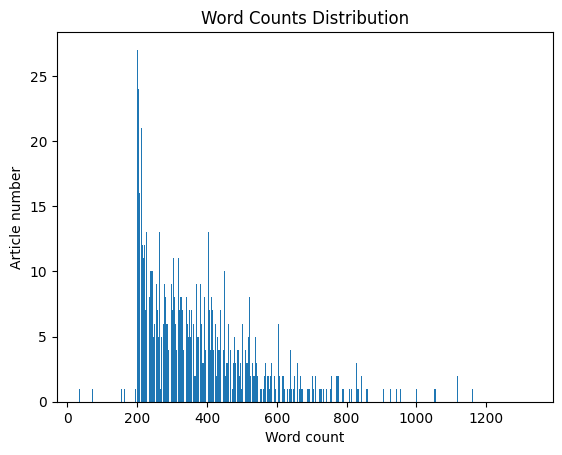

In [54]:
import matplotlib.pyplot as plt

unique_data = set(word)

data_count = dict(zip(unique_data, [word.count(x) for x in unique_data]))

plt.bar(data_count.keys(), data_count.values())
plt.xlabel('Word count')
plt.ylabel('Article number')
plt.title('Word Counts Distribution')

plt.show()

We can see that most articles have 200 to 400 words

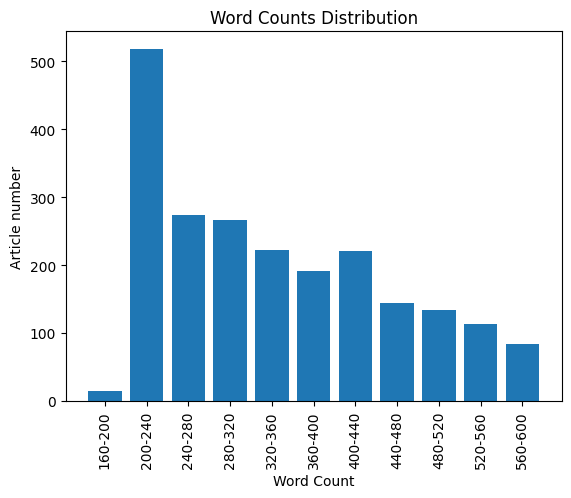

In [125]:
w1 = list(filter(lambda x: x >= 160 and x <600, word))

gs = 11
grouped_data = [[] for _ in range(gs)]
groups = []
start_value = 160
end_value = 600
step_size = 40

for i in range(start_value, end_value, step_size):
    groups.append(f"{i}-{i + step_size}")

for x in w1:
    group_index = (x-160) //40
    grouped_data[group_index].append(x)

group_data_counts = [len(group) for group in grouped_data]

plt.bar(groups, group_data_counts)
plt.xticks(groups, rotation=90)
plt.xlabel('Word Count')
plt.ylabel('Article number')
plt.title('Word Counts Distribution')

plt.show()

It can be seen that the number of articles with word counts between 200 and 240 is the largest. The number of articles with more than 240 words gradually decreases as the word count increases.

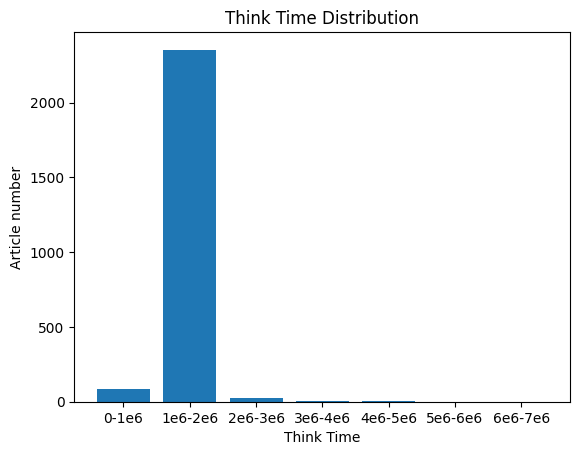

In [55]:
gs = 7
grouped_data = [[] for _ in range(gs)]
groups = [    '0-1e6',
          '1e6-2e6',
          '2e6-3e6',
          '3e6-4e6',
          '4e6-5e6',
          '5e6-6e6',
          '6e6-7e6'
          ]
for x in think:
    group_index = int(x // 1e6)
    grouped_data[group_index].append(x)

group_data_counts = [len(group) for group in grouped_data]

plt.bar(groups, group_data_counts)
plt.xlabel('Think Time')
plt.ylabel('Article number')
plt.title('Think Time Distribution')

plt.show()

It can be seen that for the vast majority of articles, the thinking time during writing is between 1000000 and 2000000.

In [77]:
t1 = list(map(int, think))
t2 = []
for x in t1:
  if x >= 1000000 and x <= 2000000:
    t2.append(x)

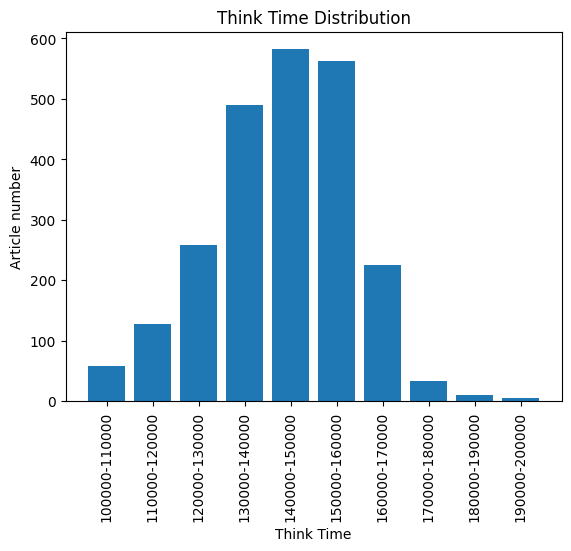

In [85]:
gs = 10
grouped_data = [[] for _ in range(gs)]
groups = [    '100000-110000',
          '110000-120000',
          '120000-130000',
          '130000-140000',
          '140000-150000',
          '150000-160000',
          '160000-170000',
          '170000-180000',
          '180000-190000',
          '190000-200000',
          ]
for x in t2:
    group_index = (x-1000000) //100000
    grouped_data[group_index].append(x)

group_data_counts = [len(group) for group in grouped_data]

plt.bar(groups, group_data_counts)
plt.xticks(groups, rotation=90)
plt.xlabel('Think Time')
plt.ylabel('Article number')
plt.title('Think Time Distribution')

plt.show()

It can be seen that the thinking time distribution of articles with writing time between 1000000 and 2000000 is basically a negatively skewed distribution.

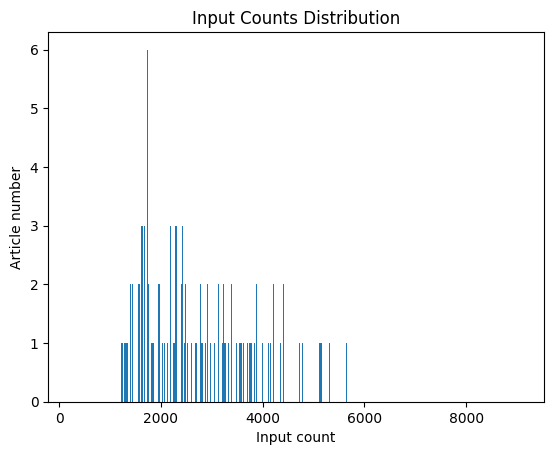

In [116]:
unique_data = set(inputs)

data_count = dict(zip(unique_data, [inputs.count(x) for x in unique_data]))

plt.bar(data_count.keys(), data_count.values())
plt.xlabel('Input count')
plt.ylabel('Article number')
plt.title('Input Counts Distribution')

plt.show()

It can be seen that the number of Input operations is mostly distributed between 2000 and 4000.

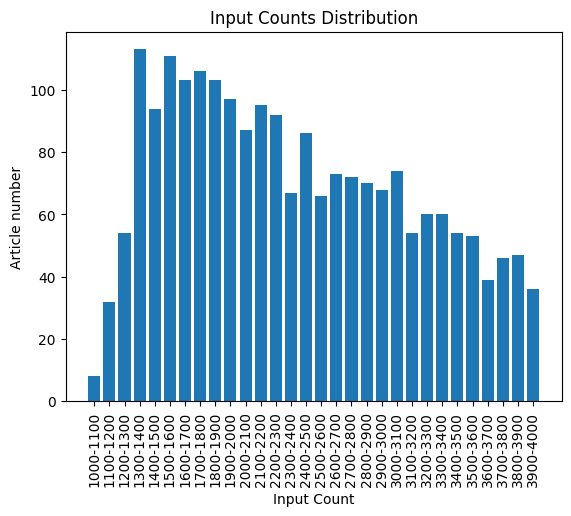

In [118]:
I1 = list(filter(lambda x: x >= 1000 and x <=4000, inputs))

gs = 30
grouped_data = [[] for _ in range(gs)]
groups = []
start_value = 1000
end_value = 4000
step_size = 100

for i in range(start_value, end_value, step_size):
    groups.append(f"{i}-{i + step_size}")

for x in I1:
    group_index = (x-1000) //100
    grouped_data[group_index].append(x)

group_data_counts = [len(group) for group in grouped_data]

plt.bar(groups, group_data_counts)
plt.xticks(groups, rotation=90)
plt.xlabel('Input Count')
plt.ylabel('Article number')
plt.title('Input Counts Distribution')

plt.show()


This figure shows the distribution of articles with Input operation counts between 1000 and 4000. It can be seen that for articles with more than 1300 Input operations, the number of articles gradually decreases as the number of Input operations in the article increases.

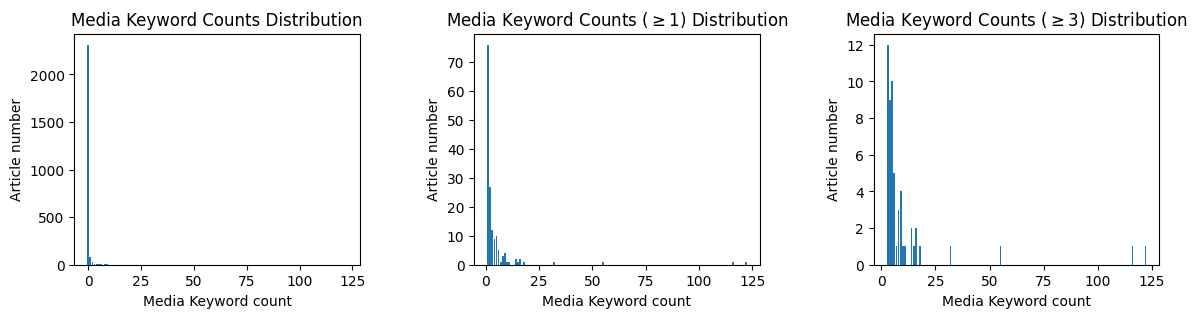

In [138]:
unique_data = set(media)

data_count = dict(zip(unique_data, [media.count(x) for x in unique_data]))

plt.subplot(1, 3, 1)  # Create first subplot
plt.bar(data_count.keys(), data_count.values())
plt.xlabel('Media Keyword count')
plt.ylabel('Article number')
plt.title('Media Keyword Counts Distribution')

m1 = list(filter(lambda x: x >= 1, media))
unique_data = set(m1)
data_count = dict(zip(unique_data, [m1.count(x) for x in unique_data]))
plt.subplot(1, 3, 2)  # Create second subplot
plt.bar(data_count.keys(), data_count.values())
plt.xlabel('Media Keyword count')
plt.ylabel('Article number')
plt.title('Media Keyword Counts ($\geq$1) Distribution')

m2 = list(filter(lambda x: x >= 3, media))
unique_data = set(m2)
data_count = dict(zip(unique_data, [m2.count(x) for x in unique_data]))
plt.subplot(1, 3, 3)  # Create second subplot
plt.bar(data_count.keys(), data_count.values())
plt.xlabel('Media Keyword count')
plt.ylabel('Article number')
plt.title('Media Keyword Counts ($\geq$3) Distribution')

fig = plt.gcf()
fig.set_size_inches(14, 3)

plt.subplots_adjust(wspace=0.4)
plt.show()



The three figures above show the information of Media Keywords. Media Keywords refer to keyboard keywords related to device volume, playback settings, and similar factors. The occurrence of these keywords indicates that the focus during the writing process was not solely on writing. Therefore, I consider the frequency of Media Keywords as a potential characteristic of writing habits. However, as observed from the figures, the occurrence of Media Keywords is actually quite low.